In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

DOMAIN = "MT"
TOP_ENTITIES = 40
MIN_COOC = 12
K_CORE = 2

In [2]:
entity_nodes = pd.read_csv('../outputs/entity_nodes.csv')
paper_nodes = pd.read_csv("../outputs/paper_nodes.csv")
knowledge_edges = pd.read_csv("../outputs/knowledge_edges.csv")

domain_papers = paper_nodes[
    paper_nodes["domain"] == DOMAIN
]["node_id"]

domain_edges = knowledge_edges[
    knowledge_edges["source"].isin(domain_papers)
]

paper_entity_map = (
    domain_edges.groupby("source")["target"]
    .apply(lambda x: list(set(x)))
)

cooc = Counter()

for entities in paper_entity_map:
    for e1, e2 in combinations(entities, 2):
        pair = tuple(sorted([e1, e2]))
        cooc[pair] += 1

In [3]:
# Filter strong pairs
strong_pairs = {
    k: v for k, v in cooc.items()
    if v >= MIN_COOC
}

G = nx.Graph()

for (e1, e2), w in strong_pairs.items():
    G.add_edge(e1, e2, weight=w)

# Keep top entities by degree
degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
top_nodes = set([n for n, _ in degree_sorted[:TOP_ENTITIES]])
G = G.subgraph(top_nodes).copy()

# Apply k-core
G = nx.k_core(G, k=K_CORE)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 40
Edges: 623


In [4]:
# Map entity_id → name
id_to_entity = dict(
    zip(entity_nodes["node_id"], entity_nodes["name"])
)

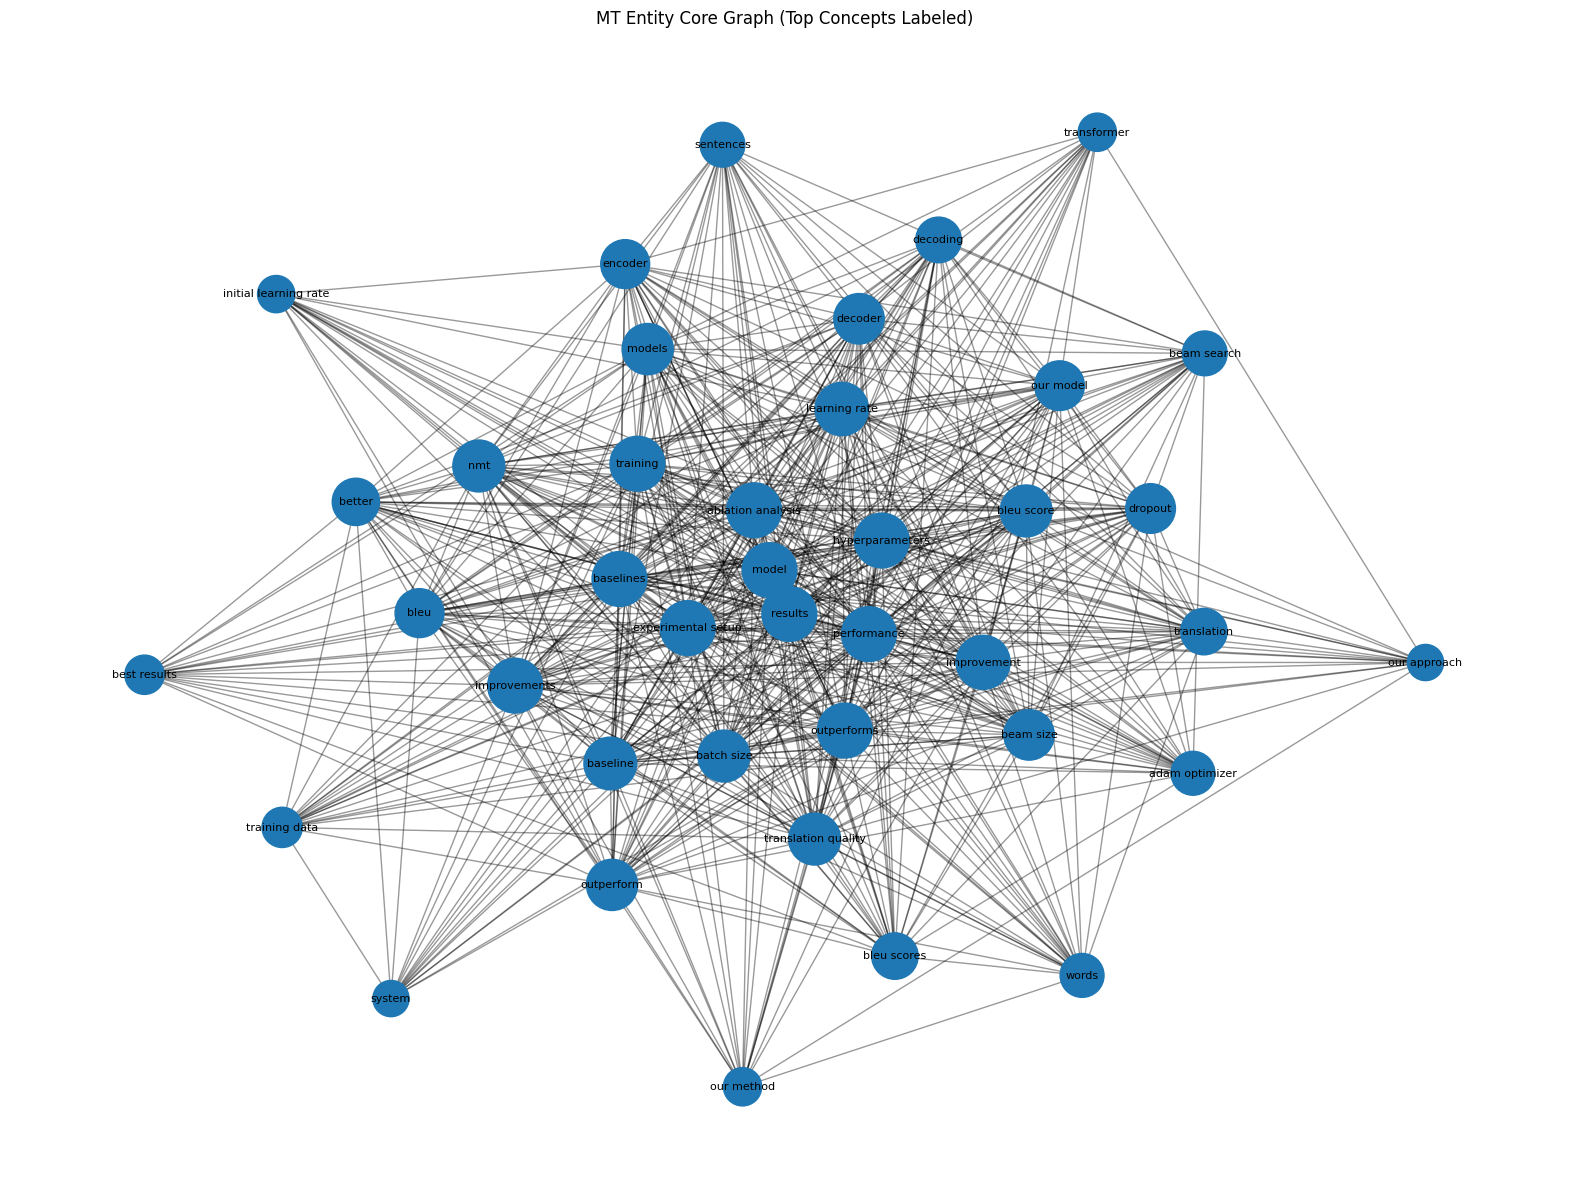

In [9]:
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, k=0.4)

sizes = [G.degree(n) * 40 for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes)
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Label top 15 entities by degree
top_entities = sorted(G.degree, key=lambda x: x[1], reverse=True)[:40]

labels = {
    node: id_to_entity[node]
    for node, _ in top_entities
}

nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title(f"{DOMAIN} Entity Core Graph (Top Concepts Labeled)")
plt.axis("off")
plt.show()